# Logistic Regression V2 - 거북목 판별 모델

V2 전처리 함수를 사용합니다. 정상 자세의 평균(baseline)을 구한 뒤,
각 샘플의 특성에서 baseline과의 차이를 특성으로 사용합니다.

In [1]:
import json
import sys
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

sys.path.append('../../shared')
from preprocessing_V2 import compute_baseline, extract_features

## 1. 데이터 로드

In [2]:
with open('../datasets/kkobuk_training_set_01.json', 'r') as f:
    train_raw = json.load(f)

with open('../datasets/kkobuk_test_set_01.json', 'r') as f:
    test1_raw = json.load(f)

with open('../datasets/kkobuk_test_set_02.json', 'r') as f:
    test2_raw = json.load(f)

with open('../datasets/kkobuk_test_set_03.json', 'r') as f:
    test3_raw = json.load(f)

train_samples = train_raw['samples'] if isinstance(train_raw, dict) else train_raw
test1_samples = test1_raw['samples'] if isinstance(test1_raw, dict) else test1_raw
test2_samples = test2_raw['samples'] if isinstance(test2_raw, dict) else test2_raw
test3_samples = test3_raw['samples'] if isinstance(test3_raw, dict) else test3_raw

print(f'Train samples: {len(train_samples)}')
print(f'Test1 samples (동일 환경): {len(test1_samples)}')
print(f'Test2 samples (카메라 각도 변경): {len(test2_samples)}')
print(f'Test3 samples (고개 살짝 돌아감): {len(test3_samples)}')

Train samples: 562
Test1 samples (동일 환경): 112
Test2 samples (카메라 각도 변경): 113
Test3 samples (고개 살짝 돌아감): 112


## 2. Baseline 계산 및 전처리

In [3]:
# 각 데이터셋의 정상 자세(label=0)로 baseline 계산
train_normal = [s for s in train_samples if s['label'] == 0]
test1_normal = [s for s in test1_samples if s['label'] == 0]
test2_normal = [s for s in test2_samples if s['label'] == 0]
test3_normal = [s for s in test3_samples if s['label'] == 0]

baseline_train = compute_baseline(train_normal)
baseline_test1 = compute_baseline(test1_normal)
baseline_test2 = compute_baseline(test2_normal)
baseline_test3 = compute_baseline(test3_normal)

print(f'Train baseline: {baseline_train}')
print(f'Test1 baseline: {baseline_test1}')
print(f'Test2 baseline: {baseline_test2}')
print(f'Test3 baseline: {baseline_test3}')

Train baseline: [0.41517802 0.3679879  0.67487791]
Test1 baseline: [0.42012271 0.36894317 0.69626094]
Test2 baseline: [0.4327244 0.3796758 0.7006159]
Test3 baseline: [0.42674704 0.37258565 0.67470336]


In [4]:
def preprocess(samples, baseline):
    X, y = [], []
    for sample in samples:
        landmarks = {
            'nose': sample['nose'],
            'leftEar': sample['leftEar'],
            'rightEar': sample['rightEar'],
            'leftShoulder': sample['leftShoulder'],
            'rightShoulder': sample['rightShoulder'],
        }
        features = extract_features(landmarks, baseline)
        X.append(features)
        y.append(sample['label'])
    return np.array(X), np.array(y)

X_train_raw, y_train = preprocess(train_samples, baseline_train)
X_test1_raw, y_test1 = preprocess(test1_samples, baseline_test1)
X_test2_raw, y_test2 = preprocess(test2_samples, baseline_test2)
X_test3_raw, y_test3 = preprocess(test3_samples, baseline_test3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test1 = scaler.transform(X_test1_raw)
X_test2 = scaler.transform(X_test2_raw)
X_test3 = scaler.transform(X_test3_raw)

print(f'Train shape: {X_train.shape}')
print(f'Test1 shape: {X_test1.shape}')
print(f'Test2 shape: {X_test2.shape}')
print(f'Test3 shape: {X_test3.shape}')
print(f'Train label 분포: 0={np.sum(y_train==0)}, 1={np.sum(y_train==1)}')
print(f'Test1 label 분포: 0={np.sum(y_test1==0)}, 1={np.sum(y_test1==1)}')
print(f'Test2 label 분포: 0={np.sum(y_test2==0)}, 1={np.sum(y_test2==1)}')
print(f'Test3 label 분포: 0={np.sum(y_test3==0)}, 1={np.sum(y_test3==1)}')

Train shape: (562, 3)
Test1 shape: (112, 3)
Test2 shape: (113, 3)
Test3 shape: (112, 3)
Train label 분포: 0=274, 1=288
Test1 label 분포: 0=54, 1=58
Test2 label 분포: 0=55, 1=58
Test3 label 분포: 0=54, 1=58


## 3. 특성 분포 시각화

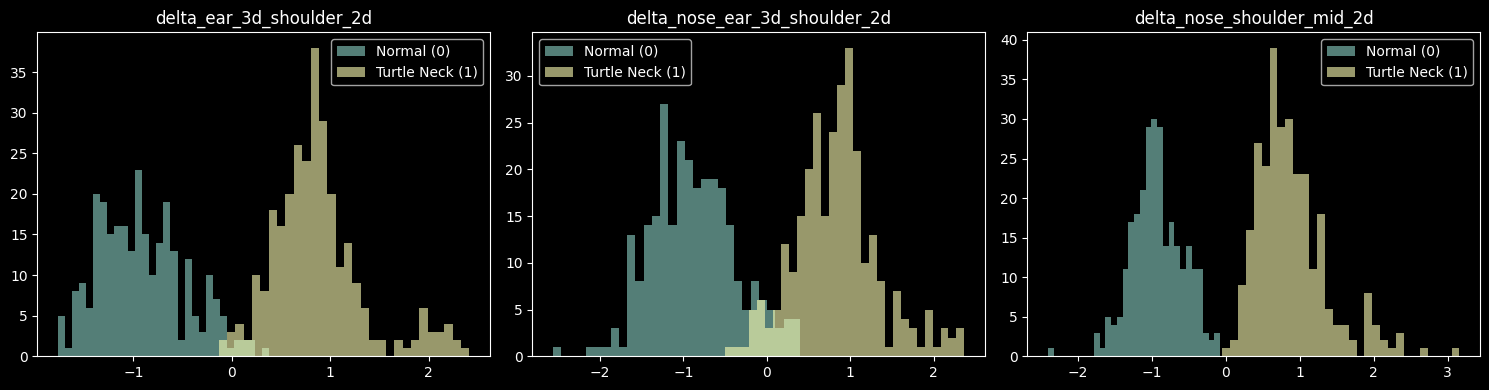

In [5]:
feature_names = ['delta_ear_3d_shoulder_2d', 'delta_nose_ear_3d_shoulder_2d', 'delta_nose_shoulder_mid_2d']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (ax, name) in enumerate(zip(axes, feature_names)):
    ax.hist(X_train[y_train == 0, i], bins=30, alpha=0.6, label='Normal (0)')
    ax.hist(X_train[y_train == 1, i], bins=30, alpha=0.6, label='Turtle Neck (1)')
    ax.set_title(name)
    ax.legend()
plt.tight_layout()
plt.show()

## 4. 로지스틱 회귀 학습

In [6]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

print('학습 완료')

학습 완료


## 5. 평가

In [7]:
y_pred_train = model.predict(X_train)
y_pred_test1 = model.predict(X_test1)
y_pred_test2 = model.predict(X_test2)
y_pred_test3 = model.predict(X_test3)

print(f'Train Accuracy:                      {accuracy_score(y_train, y_pred_train):.4f}')
print(f'Test1 Accuracy (동일 환경):          {accuracy_score(y_test1, y_pred_test1):.4f}')
print(f'Test2 Accuracy (카메라 각도 변경):   {accuracy_score(y_test2, y_pred_test2):.4f}')
print(f'Test3 Accuracy (고개 살짝 돌아감):   {accuracy_score(y_test3, y_pred_test3):.4f}')

Train Accuracy:                      1.0000
Test1 Accuracy (동일 환경):          0.9821
Test2 Accuracy (카메라 각도 변경):   0.9912
Test3 Accuracy (고개 살짝 돌아감):   1.0000


## 6. Confusion Matrix

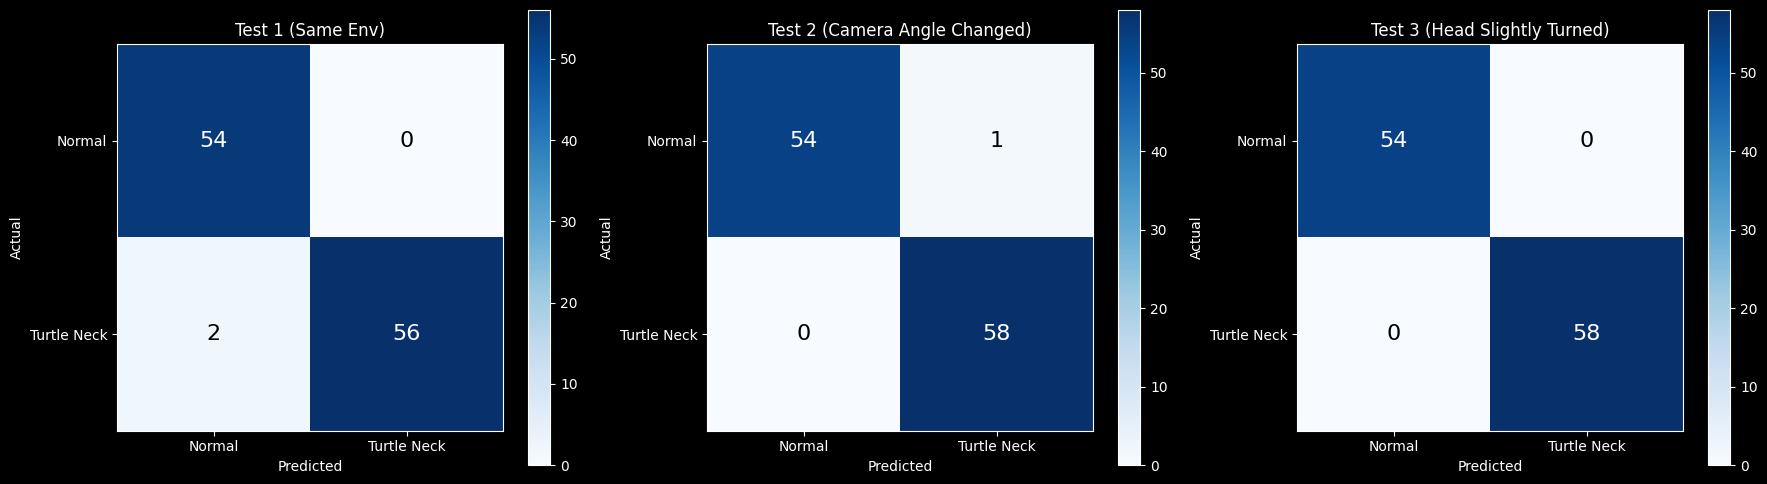

In [8]:
cm1 = confusion_matrix(y_test1, y_pred_test1)
cm2 = confusion_matrix(y_test2, y_pred_test2)
cm3 = confusion_matrix(y_test3, y_pred_test3)
labels = ['Normal', 'Turtle Neck']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

for ax, cm, title in [(ax1, cm1, 'Test 1 (Same Env)'), (ax2, cm2, 'Test 2 (Camera Angle Changed)'), (ax3, cm3, 'Test 3 (Head Slightly Turned)')]:
    im = ax.imshow(cm, cmap='Blues')
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black', fontsize=16)

plt.tight_layout()
plt.show()

## 7. 특성 중요도

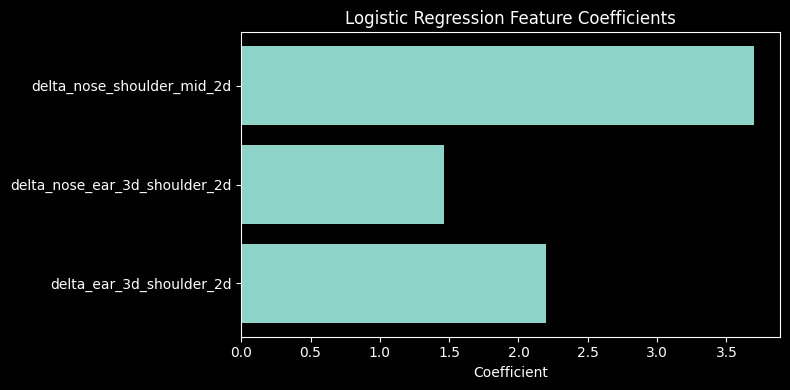

In [9]:
coefficients = model.coef_[0]

plt.figure(figsize=(8, 4))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient')
plt.title('Logistic Regression Feature Coefficients')
plt.tight_layout()
plt.show()